# Imports

In [ ]:
import numpy as np 
import pickle 
import networkx as nx 
from scipy.spatial.distance import cosine
import random
from operator import itemgetter
from collections import OrderedDict
from tabulate import tabulate
from termcolor import colored
import logging
import copy
import os

import matplotlib.pyplot as plt
import tqdm
from scipy.stats import norm
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity

# Create a Graph

In [ ]:
class Graph():
    def __init__(self, dataset='Market',number_ids = 220, epsilon_graph= 0, knn_graph= 0):
        with open(f'datasets/{dataset}/feat.pkl', 'rb') as f :
            features = pickle.load(f)  # (19281, 2048) [:100,:]
        with open(f'datasets/{dataset}/ids.pkl', 'rb') as f :
            ids = pickle.load(f) # 751 unique id [:100]
        with open(f'datasets/{dataset}/camids.pkl', 'rb') as f :
            camids = pickle.load(f)  # 6 unique camids [:100]
        self.epsilon_graph = epsilon_graph
        self.knn_graph = knn_graph
        
        self.selected_ids = np.unique(ids)[:number_ids]
        self.selector = list(map(self.select, ids))
        print('selected: ', sum(self.selector))
        features = features[self.selector,:]
        ids = ids[self.selector]
        camids = camids[self.selector]

        random.seed(10)
        self.train_mask = random.sample(range(len(ids)), k=int(round(len(ids)*0.7)))
        self.test_mask = list(set(range(len(ids))) - set(self.train_mask))
        
        self.train_ids = ids[self.train_mask]
        self.train_features = features[self.train_mask, :]
        self.train_camids = camids[self.train_mask]
        
        self.test_ids = ids[self.test_mask]
        self.test_features = features[self.test_mask, :]
        self.test_camids = camids[self.test_mask]

        del features
        del ids
        del camids

        self.graph = nx.DiGraph()
        self.graph.add_nodes_from(range(len(self.train_ids)))

        cosine_dist = abs (1 - cosine_similarity(self.train_features))

        if self.knn_graph>0 :
              cosine_dist[cosine_dist>np.sort(cosine_dist)[:,int(self.knn_graph)]] = 10 

        print('min distance', np.min(np.min(cosine_dist)))
        print('max distance', np.max(np.max(cosine_dist)))

        edges = []
        for node1 in self.graph.nodes() :
          for node2 in self.graph.nodes() :
            if node1 != node2:
              if (self.epsilon_graph>0 and cosine_dist[node1,node2]<=self.epsilon_graph and self.knn_graph==0) or (self.epsilon_graph==0 and self.knn_graph==0) :
                edges.append((node1,node2, cosine_dist[node1,node2]))
              if self.knn_graph>0 and cosine_dist[node1,node2]<10:
                edges.append((node1,node2, cosine_dist[node1,node2]))

        print('edges: ',len(edges))
        del cosine_dist
        self.graph.add_weighted_edges_from(edges) 

        id_ = 0
        nx.set_node_attributes(self.graph, id_, "ID")
        n = 0 
        for train_id in self.train_ids: 
            self.graph.update(nodes=[(n,{'ID':train_id})])
            n+= 1 
        
        camid_ = 0
        nx.set_node_attributes(self.graph, id_, "CAMID")
        n = 0 
        for train_camid in self.train_camids: 
            self.graph.update(nodes=[(n,{'CAMID':train_camid})])
            n+= 1 
        
        print('nodes: ', len(self.graph.nodes))
        
    def select(self,id):
      return id in self.selected_ids

    def addQueries(self, features, ids, camids):
      previous_nodes=copy.deepcopy(self.graph.nodes())
      max_node = max(self.graph.nodes())+1
      nodes = list(range(max_node, max_node+len(ids)))
      self.graph.add_nodes_from(nodes)
      n = 0 
      for camid in camids: 
          self.graph.update(nodes=[(nodes[n],{'CAMID':camid})])
          self.graph.update(nodes=[(nodes[n],{'ID':ids[n]})])
          n+= 1 

      cosine_dist = 1- cosine_similarity(features, self.train_features)
      if self.knn_graph>0 :
        sorted_ = np.sort(cosine_dist)[:,int(self.knn_graph)]
        for i, row in enumerate(cosine_dist): 
          cosine_dist[i, row>sorted_[i]] = 10

      edges = []
      for node1 in nodes:
        for node2 in previous_nodes:
          if (self.epsilon_graph>0 and cosine_dist[node1-max_node, node2]<=self.epsilon_graph and self.knn_graph==0) or (self.epsilon_graph==0 and self.knn_graph==0):
            edges.append((node1, node2, cosine_dist[node1-max_node, node2]))
          if self.knn_graph>0 and cosine_dist[node1-max_node, node2]<10:
            edges.append((node1,node2, cosine_dist[node1-max_node, node2]))

      del cosine_dist
      self.graph.add_weighted_edges_from(edges) 

      print('edges: ',len(self.graph.edges()))
      print('nodes: ',len(self.graph.nodes()))

In [ ]:
graph=Graph()

In [ ]:
# graph.graph.nodes(data=True)

In [ ]:
# graph.graph.edges(data=True)

# Test Queries

In [ ]:
def print_csv_format(results):
    """
    Print main metrics in a format similar to Detectron2,
    so that they are easy to copypaste into a spreadsheet.
    Args:
        results (OrderedDict): {metric -> score}
    """
    # unordered results cannot be properly printed

    logger = logging.getLogger(__name__)

    dataset_name = results.pop('dataset')
    metrics = ["Dataset"] + [k for k in results]
    csv_results = [(dataset_name, *list(results.values()))]

    # tabulate it
    table = tabulate(
        csv_results,
        tablefmt="pipe",
        floatfmt=".2f",
        headers=metrics,
        numalign="left",
    )

    print("Evaluation results in csv format: \n" + colored(table, "cyan"))

In [ ]:
def nearest_neighbors(graph, node):
    return np.array(list(map(itemgetter(1),
                    sorted([(e[2]['weight'], e[1])
                            for e in graph.edges(node, data=True)]))))

In [ ]:
def queries_in_graph(graph, queries):
  N = len(graph.train_ids)
  indices = np.zeros((len(queries), N), dtype='int')
  for i in range(len(queries)):
    nn = nearest_neighbors(graph.graph, queries[i])
    indices[i,:len(nn)] = nn
    indices[i,len(nn):] = list(set(range(N)) - set(indices[i,:len(nn)]))
    
  return indices

In [ ]:
def eval_metrics(dataset, indices, q_ids, g_ids, q_camids, g_camids, max_rank=10):
    """Evaluation of the queries output 
    """
    num_q, num_g = indices.shape

    if num_g < max_rank:
        max_rank = num_g
        print('Note: number of gallery samples is quite small, got {}'.format(num_g))

    # compute cmc curve for each query
    all_cmc = []
    all_AP = []
    all_INP = []
    num_valid_q = 0  # number of valid query

    i=0
    for q_idx in range(num_q):
        # get query pid and camid
        q_id = q_ids[q_idx]
        q_camid = q_camids[q_idx]

        order = indices[q_idx]
        remove = (g_ids[order] == q_id) & (g_camids[order] == q_camid)
        keep = np.invert(remove)

        # compute cmc curve
        matches = (g_ids[order] == q_id).astype(np.int32)
        raw_cmc = matches[keep]  # binary vector, positions with value 1 are correct matches

        if not np.any(raw_cmc):
            # this condition is true when query identity does not appear in gallery
            i+=1
            continue

        cmc = raw_cmc.cumsum()

        pos_idx = np.where(raw_cmc == 1)
        max_pos_idx = np.max(pos_idx)
        inp = cmc[max_pos_idx] / (max_pos_idx + 1.0)
        all_INP.append(inp)

        cmc[cmc > 1] = 1

        all_cmc.append(cmc[:max_rank])
        num_valid_q += 1.

        # compute average precision
        num_rel = raw_cmc.sum()
        tmp_cmc = raw_cmc.cumsum()
        tmp_cmc = [x / (i + 1.) for i, x in enumerate(tmp_cmc)]
        tmp_cmc = np.asarray(tmp_cmc) * raw_cmc
        AP = tmp_cmc.sum() / num_rel
        all_AP.append(AP)

    print('number of queries that do not exist in the gallery :', i)
    assert num_valid_q > 0, 'Error: all query identities do not appear in gallery'

    all_cmc = np.asarray(all_cmc).astype(np.float32)
    all_cmc = all_cmc.sum(0) / num_valid_q

    results = OrderedDict()
    results['dataset'] = dataset
    mAP = np.mean(all_AP)
    mINP = np.mean(all_INP)
    for r in [1, 5, 10]:
        results['Rank-{}'.format(r)] = all_cmc[r - 1] * 100
    results['mAP'] = mAP * 100
    results['mINP'] = mINP * 100
    results["metric"] = (mAP + all_cmc[0]) / 2 * 100

    print_csv_format(results)
    return all_cmc, all_AP, all_INP

# Reidentification using initial distances 

## Market

In [ ]:
graph=Graph(dataset='Market')

In [ ]:
max_node = max(graph.graph.nodes())+1
queries = list(range(max_node, max_node+len(graph.test_ids)))

In [ ]:
graph.addQueries( graph.test_features, graph.test_ids, graph.test_camids)

edges:  44925688
nodes:  8012


In [ ]:
indices = queries_in_graph(graph, queries)

In [ ]:
all_cmc, all_AP, all_INP = eval_metrics('Market', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

number of queries that do not exist in the gallery : 0
Evaluation results in csv format: 
| Dataset   | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:----------|:---------|:---------|:----------|:------|:-------|:---------|
| Market    | 90.14    | 96.13    | 97.50     | 72.92 | 49.87  | 81.53    |


### $\epsilon$-Graph

#### $\epsilon$=0.05


In [ ]:
graph=Graph(dataset='Market', epsilon_graph=0.05)

selected:  8012
min distance 0.0
max distance 0.40666026
edges:  58962
nodes:  5608


In [ ]:
max_node = max(graph.graph.nodes())+1
queries = list(range(max_node, max_node+len(graph.test_ids)))

In [ ]:
graph.addQueries( graph.test_features, graph.test_ids, graph.test_camids)

edges:  84131
nodes:  8012


In [ ]:
indices = queries_in_graph(graph, queries)

In [ ]:
all_cmc, all_AP, all_INP = eval_metrics('Market', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

number of queries that do not exist in the gallery : 0
Evaluation results in csv format: 
| Dataset   | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:----------|:---------|:---------|:----------|:------|:-------|:---------|
| Market    | 67.22    | 90.93    | 95.22     | 49.16 | 21.45  | 58.19    |


#### $\epsilon$=0.1



In [ ]:
graph=Graph(dataset='Market', epsilon_graph=0.1)

selected:  8012
min distance 0.0
max distance 0.40666026
edges:  1132814
nodes:  5608


In [ ]:
max_node = max(graph.graph.nodes())+1
queries = list(range(max_node, max_node+len(graph.test_ids)))

In [ ]:
graph.addQueries( graph.test_features, graph.test_ids, graph.test_camids)

edges:  1605334
nodes:  8012


In [ ]:
indices = queries_in_graph(graph, queries)

In [ ]:
all_cmc, all_AP, all_INP = eval_metrics('Market', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

number of queries that do not exist in the gallery : 0
Evaluation results in csv format: 
| Dataset   | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:----------|:---------|:---------|:----------|:------|:-------|:---------|
| Market    | 90.14    | 96.13    | 97.50     | 68.74 | 49.11  | 79.44    |


#### $\epsilon$=0.2

In [ ]:
graph=Graph(dataset='Market', epsilon_graph=0.2)

selected:  8012
min distance 0.0
max distance 0.40666026
edges:  29100184
nodes:  5608


In [ ]:
max_node = max(graph.graph.nodes())+1
queries = list(range(max_node, max_node+len(graph.test_ids)))

In [ ]:
graph.addQueries( graph.test_features, graph.test_ids, graph.test_camids)

edges:  41565699
nodes:  8012


In [ ]:
indices = queries_in_graph(graph, queries)

In [ ]:
all_cmc, all_AP, all_INP = eval_metrics('Market', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

number of queries that do not exist in the gallery : 0
Evaluation results in csv format: 
| Dataset   | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:----------|:---------|:---------|:----------|:------|:-------|:---------|
| Market    | 90.14    | 96.13    | 97.50     | 72.89 | 49.88  | 81.52    |


### KNN-Graph

#### 100 NN-Graph

In [ ]:
graph=Graph(dataset='Market',number_ids = 220, epsilon_graph= 0, knn_graph= 100)

selected:  8012
min distance 0.0
max distance 10.0
edges:  560802
nodes:  5608


In [ ]:
max_node = max(graph.graph.nodes())+1
queries = list(range(max_node, max_node+len(graph.test_ids)))

In [ ]:
graph.addQueries( graph.test_features, graph.test_ids, graph.test_camids)

edges:  803607
nodes:  8012


In [ ]:
indices = queries_in_graph(graph, queries)

In [ ]:
all_cmc, all_AP, all_INP = eval_metrics('Market', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

number of queries that do not exist in the gallery : 0
Evaluation results in csv format: 
| Dataset   | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:----------|:---------|:---------|:----------|:------|:-------|:---------|
| Market    | 90.14    | 96.13    | 97.50     | 67.64 | 48.51  | 78.89    |


#### 50 NN-Graph

In [ ]:
graph=Graph(dataset='Market',number_ids = 220, epsilon_graph= 0, knn_graph= 50)

selected:  8012
min distance 0.0
max distance 10.0
edges:  280400
nodes:  5608


In [ ]:
max_node = max(graph.graph.nodes())+1
queries = list(range(max_node, max_node+len(graph.test_ids)))

In [ ]:
graph.addQueries( graph.test_features, graph.test_ids, graph.test_camids)

edges:  403004
nodes:  8012


In [ ]:
indices = queries_in_graph(graph, queries)

In [ ]:
all_cmc, all_AP, all_INP = eval_metrics('Market', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

number of queries that do not exist in the gallery : 0
Evaluation results in csv format: 
| Dataset   | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:----------|:---------|:---------|:----------|:------|:-------|:---------|
| Market    | 90.14    | 96.13    | 97.50     | 66.45 | 45.77  | 78.30    |


#### 10 NN-Graph

In [ ]:
graph=Graph(dataset='Market',number_ids = 220, epsilon_graph= 0, knn_graph= 10)

selected:  8012
min distance 0.0
max distance 10.0
edges:  56080
nodes:  5608


In [ ]:
max_node = max(graph.graph.nodes())+1
queries = list(range(max_node, max_node+len(graph.test_ids)))

In [ ]:
graph.addQueries( graph.test_features, graph.test_ids, graph.test_camids)

edges:  82524
nodes:  8012


In [ ]:
indices = queries_in_graph(graph, queries)

In [ ]:
all_cmc, all_AP, all_INP = eval_metrics('Market', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

number of queries that do not exist in the gallery : 0
Evaluation results in csv format: 
| Dataset   | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:----------|:---------|:---------|:----------|:------|:-------|:---------|
| Market    | 88.10    | 95.22    | 97.30     | 42.41 | 17.59  | 65.26    |


## SmallVeriWild

In [ ]:
graph=Graph(dataset='VeriWildSmall',number_ids = 600)

selected:  8456
min distance 0.0
max distance 1.2904128
edges:  35028642
nodes:  5919


In [ ]:
max_node = max(graph.graph.nodes())+1
queries = list(range(max_node, max_node+len(graph.test_ids)))

In [ ]:
graph.addQueries( graph.test_features, graph.test_ids, graph.test_camids)

edges:  50045145
nodes:  8456


In [ ]:
indices = queries_in_graph(graph, queries)

In [ ]:
all_cmc, all_AP, all_INP = eval_metrics('VeriWildSmall', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

number of queries that do not exist in the gallery : 10
Evaluation results in csv format: 
| Dataset       | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:--------------|:---------|:---------|:----------|:------|:-------|:---------|
| VeriWildSmall | 98.10    | 99.53    | 99.88     | 95.64 | 88.62  | 96.87    |


## MediumVeriWild

In [ ]:
graph=Graph(dataset='VeriWildMedium',number_ids = 600)

8296
5807


In [ ]:
max_node = max(graph.graph.nodes())+1
queries = list(range(max_node, max_node+len(graph.test_ids)))

In [ ]:
graph.addQueries( graph.test_features, graph.test_ids, graph.test_camids)

In [ ]:
indices = queries_in_graph(graph, queries)

In [ ]:
all_cmc, all_AP, all_INP = eval_metrics('VeriWildMedium', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

number of queries that do not exist in the gallery : 9
Evaluation results in csv format: 
| Dataset        | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:---------------|:---------|:---------|:----------|:------|:-------|:---------|
| VeriWildMedium | 98.23    | 99.48    | 99.80     | 95.09 | 88.03  | 96.66    |


## LargeVeriWild

In [ ]:
graph=Graph(dataset='VeriWildLarge',number_ids = 600)

8267
5787


In [ ]:
max_node = max(graph.graph.nodes())+1
queries = list(range(max_node, max_node+len(graph.test_ids)))

In [ ]:
graph.addQueries( graph.test_features, graph.test_ids, graph.test_camids)

In [ ]:
indices = queries_in_graph(graph, queries)

In [ ]:
all_cmc, all_AP, all_INP = eval_metrics('VeriWildLarge', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

number of queries that do not exist in the gallery : 11
Evaluation results in csv format: 
| Dataset       | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:--------------|:---------|:---------|:----------|:------|:-------|:---------|
| VeriWildLarge | 98.46    | 99.64    | 99.80     | 95.70 | 89.50  | 97.08    |


# Visualization

In [ ]:
! unzip /content/drive/MyDrive/MVA_CS_HW/ADL_NLP_MLNS/MLNS/projet/data/Market-1501-v15.09.15.zip 
! mkdir datasets
! cp -R Market-1501-v15.09.15/  datasets/
! rm -R Market-1501-v15.09.15/  

In [ ]:
import glob
import re
import os.path as osp
import imageio as io

In [ ]:
with open(path+f'datasets/Market/img_paths.pkl', 'rb') as f :
  image_paths = pickle.load(f)  

In [ ]:
all_paths = []
for batch_paths in image_paths:
  all_paths.extend(batch_paths)

In [ ]:
graph=Graph(dataset='Market' )

selected:  8012
min distance 0.0
max distance 0.40666026
edges:  31444056
nodes:  5608


In [ ]:
all_paths = np.array(all_paths)
query_paths = all_paths[graph.selector][graph.test_mask]
gallery_paths = all_paths[graph.selector][graph.train_mask]

In [ ]:
max_node = max(graph.graph.nodes())+1
queries = list(range(max_node, max_node+len(graph.test_ids)))

In [ ]:
graph.addQueries(graph.test_features, graph.test_ids, graph.test_camids)

edges:  44925688
nodes:  8012


In [ ]:
indices = queries_in_graph(graph, queries)

In [ ]:
all_cmc, all_AP, all_INP = eval_metrics('Market', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

number of queries that do not exist in the gallery : 0
Evaluation results in csv format: 
| Dataset   | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:----------|:---------|:---------|:----------|:------|:-------|:---------|
| Market    | 90.14    | 96.13    | 97.50     | 72.92 | 49.87  | 81.53    |


In [ ]:
class MarketVisualizer:
    def __init__(self, all_ap, indices, q_ids, g_ids, q_camids, g_camids, query_paths, gallery_paths):
        self.all_ap = all_ap
        self.q_ids = q_ids
        self.g_ids = g_ids
        self.q_camids = q_camids
        self.g_camids = g_camids
        self.indices = indices
        self.matches = (g_ids[self.indices] == q_ids[:, np.newaxis]).astype(np.int32)
        self.num_query = len(q_ids)
        self.query_paths = query_paths
        self.gallery_paths = gallery_paths

    def get_matched_result(self, q_index):
        q_id = self.q_ids[q_index]
        q_camid = self.q_camids[q_index]
        order = self.indices[q_index]
        cmc = self.matches[q_index]
        sort_idx = order
        return cmc, sort_idx

    def save_rank_result(self, query_indices, max_rank=5, vis_label=False, label_sort='ascending',):
        if vis_label:
            fig, axes = plt.subplots(2, max_rank + 1, figsize=(3 * max_rank, 12))
        else:
            fig, axes = plt.subplots(1, max_rank + 1, figsize=(3 * max_rank, 6))
        for cnt, q_idx in enumerate(tqdm.tqdm(query_indices)):
            all_imgs = []
            cmc, sort_idx = self.get_matched_result(q_idx)
            query_img = io.imread(self.query_paths[q_idx])
            cam_id = self.q_camids[q_idx]
            query_name = self.query_paths[q_idx].split('/')[-1]
            all_imgs.append(query_img)
            plt.clf()
            ax = fig.add_subplot(1, max_rank + 1, 1)
            ax.imshow(query_img)
            ax.set_title('query/cam{}'.format(cam_id), size=20)
            ax.axis("off")
            for i in range(max_rank):
                if vis_label:
                    ax = fig.add_subplot(2, max_rank + 1, i + 2)
                else:
                    ax = fig.add_subplot(1, max_rank + 1, i + 2)
                g_idx = sort_idx[i]
                gallery_img = io.imread(self.gallery_paths[g_idx])
                cam_id = self.g_camids[g_idx]
                all_imgs.append(gallery_img)
                if cmc[i] == 1:
                    label = 'true'
                    ax.add_patch(plt.Rectangle(xy=(0, 0), width=gallery_img.shape[1] - 1,
                                               height=gallery_img.shape[0] - 1, edgecolor=(0,1,0),
                                               fill=False, linewidth=5))
                else:
                    label = 'false'
                    ax.add_patch(plt.Rectangle(xy=(0, 0), width=gallery_img.shape[1] - 1,
                                               height=gallery_img.shape[0] - 1,
                                               edgecolor=(1, 0, 0), fill=False, linewidth=5))
                ax.imshow(gallery_img)
                weight = graph.graph.get_edge_data(q_idx+max_node , sort_idx[i])['weight']
                ax.set_title(f'{weight:.3f}/{label}/cam{cam_id}', size=20)
                ax.axis("off")
           
            if vis_label:
                label_indice = np.where(cmc == 1)[0]
                if label_sort == "ascending": label_indice = label_indice[::-1]
                label_indice = label_indice[:max_rank]
                for i in range(max_rank):
                    if i >= len(label_indice): break
                    j = label_indice[i]
                    g_idx = sort_idx[j]
                    gallery_img = io.imread(self.gallery_paths[g_idx])
                    cam_id = self.g_camids[g_idx]
                    ax = fig.add_subplot(2, max_rank + 1, max_rank + 3 + i)
                    ax.add_patch(plt.Rectangle(xy=(0, 0), width=gallery_img.shape[1] - 1,
                                               height=gallery_img.shape[0] - 1,
                                               edgecolor=(0, 1, 0),
                                               fill=False, linewidth=5))
                    ax.imshow(gallery_img)
                    if sort_idx[j] in graph.graph[q_idx+max_node].keys():
                      weight = graph.graph.get_edge_data(q_idx+max_node , sort_idx[j])['weight']
                    else:
                      weight = 2
                    ax.set_title(f'{weight:.3f}/cam{cam_id}', size=20)
                    ax.axis("off")

            plt.tight_layout()
            filepath = os.path.join("{}.jpg".format(cnt))
            fig.savefig(filepath)

    def vis_rank_list(self, vis_label, num_vis=20, rank_sort="ascending", label_sort="ascending", max_rank=10):
    
        assert rank_sort in ['ascending', 'descending'], "{} not match [ascending, descending]".format(rank_sort)

        query_indices = np.argsort(self.all_ap)
        if rank_sort == 'descending': query_indices = query_indices[::-1]

        query_indices = query_indices[int(num_vis)-1:int(num_vis)]
        self.save_rank_result(query_indices, max_rank, vis_label, label_sort)

    

In [ ]:
MarketVis = MarketVisualizer(all_AP, indices, graph.test_ids, graph.train_ids, graph.test_camids, graph.train_camids, query_paths, gallery_paths)

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


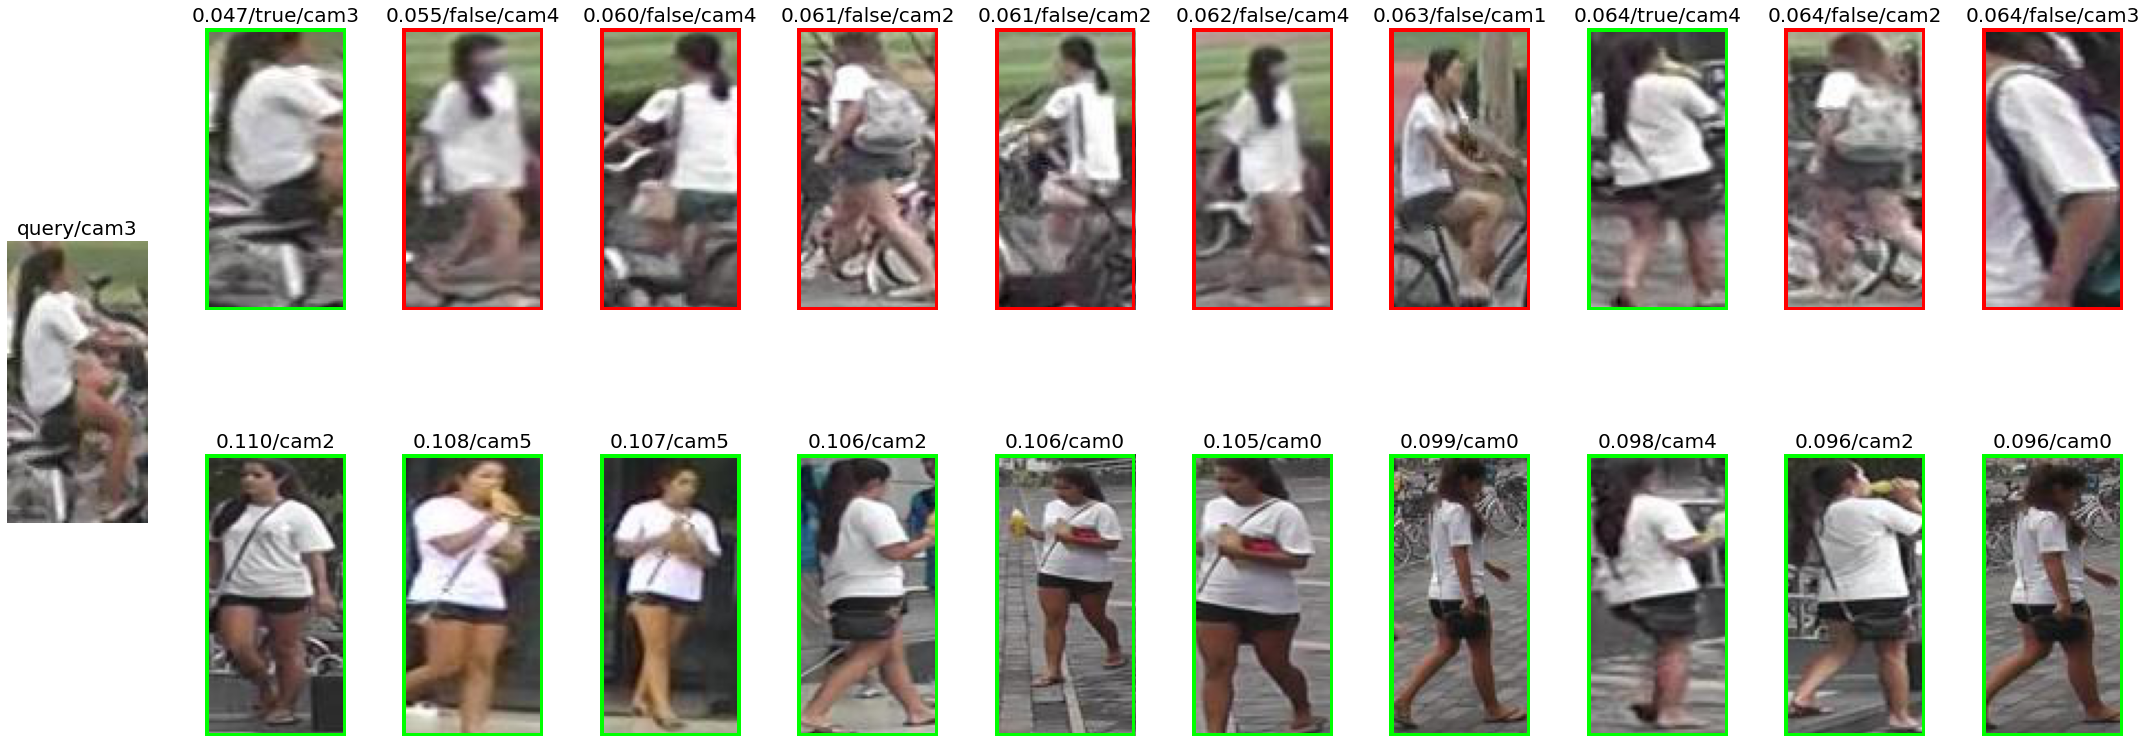

In [ ]:
MarketVis.vis_rank_list(True, num_vis=20, rank_sort="ascending", label_sort="ascending", max_rank=10)

# Graph Features 

## Utils

In [ ]:
from math import log

In [ ]:
def evaluate(graph, dataset='Market'):
  max_node = max(graph.graph.nodes())+1
  queries = list(range(max_node, max_node+len(graph.test_ids)))
  graph.addQueries( graph.test_features, graph.test_ids, graph.test_camids)
  indices = queries_in_graph(graph, queries)
  all_cmc, all_AP, all_INP = eval_metrics(dataset, indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

In [ ]:
def apply_prediction(G, func, ebunch=None):
    """Applies the given function to each edge in the specified iterable
    of edges.
    """
    if ebunch is None:
        ebunch = nx.non_edges(G)
    return ((u, v, func(u, v)) for u, v in ebunch)

In [ ]:
def common_neighbors(G, u, v):
    """Returns the common neighbors of two nodes in a graph.
    """
    if u not in G:
        raise nx.NetworkXError("u is not in the graph.")
    if v not in G:
        raise nx.NetworkXError("v is not in the graph.")

    # Return a generator explicitly instead of yielding so that the above
    # checks are executed eagerly.
    return (w for w in G[u] if w in G[v] and w not in (u, v))

In [ ]:
def jaccard_coefficient(G, ebunch=None):
    """Compute the Jaccard coefficient of all node pairs in ebunch.

    """

    def predict(u, v):
        union_size = len(set(G[u]) | set(G[v]))
        if union_size == 0:
            return 0
        return len(list(common_neighbors(G, u, v))) / union_size

    return apply_prediction(G, predict, ebunch)

In [ ]:
def adamic_adar_index(G, ebunch=None):
    """Compute the Adamic-Adar index of all node pairs in ebunch.
    """

    def predict(u, v):
        return sum(1 / log(G.degree(w)) for w in common_neighbors(G, u, v))

    return apply_prediction(G, predict, ebunch)

In [ ]:
def add_jaccard(graph, alpha = 0.2):
  jaccard_coefficients = jaccard_coefficient(graph, graph.edges())
  for e1, e2 in graph.edges():
    graph[e1][e2]['weight']+= alpha *(1- next(jaccard_coefficients)[2])

In [ ]:
def replace_jaccard(graph):
  jaccard_coefficients = jaccard_coefficient(graph, graph.edges())
  for e1, e2 in graph.edges():
    graph[e1][e2]['weight']= (1- next(jaccard_coefficients)[2])

In [ ]:
def add_adamic_adar(graph, alpha = 0.5):
  adamic_adar = adamic_adar_index(graph, graph.edges())
  for e1, e2 in graph.edges():
    graph[e1][e2]['weight']+= 0.5 *(1- next(adamic_adar)[2]/100)

In [ ]:
def replace_adamic_adar(graph):
  adamic_adar = adamic_adar_index(graph, graph.edges())
  for e1, e2 in graph.edges():
    graph[e1][e2]['weight']= (1- next(adamic_adar)[2]/100)

## Market

### jaccard_coefficient

In [ ]:
graph=Graph(dataset='Market', epsilon_graph=0.2)

selected:  8012
min distance 0.0
max distance 0.40666026
edges:  29100184
nodes:  5608


In [ ]:
evaluate(graph, dataset='Market')

edges:  41565699
nodes:  8012
number of queries that do not exist in the gallery : 0
Evaluation results in csv format: 
| Dataset   | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:----------|:---------|:---------|:----------|:------|:-------|:---------|
| Market    | 90.14    | 96.13    | 97.50     | 72.89 | 49.88  | 81.52    |


In [21]:
replace_jaccard(graph.graph)

In [ ]:
queries = list(range(5608, 8012))
indices = queries_in_graph(graph, queries)
all_cmc, all_AP, all_INP = eval_metrics('Market', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

In [ ]:
graph=Graph(dataset='Market', epsilon_graph=0.2)

In [ ]:
evaluate(graph, dataset='Market')

In [ ]:
add_jaccard(graph.graph)

In [ ]:
queries = list(range(5608, 8012))
indices = queries_in_graph(graph, queries)
all_cmc, all_AP, all_INP = eval_metrics('Market', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

### adamic_adar_index

In [ ]:
graph=Graph(dataset='Market', epsilon_graph=0.1)

selected:  8012
min distance 0.0
max distance 0.40666026
edges:  1132814
nodes:  5608


In [ ]:
evaluate(graph, dataset='Market')

edges:  1605334
nodes:  8012
number of queries that do not exist in the gallery : 0
Evaluation results in csv format: 
| Dataset   | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:----------|:---------|:---------|:----------|:------|:-------|:---------|
| Market    | 90.14    | 96.13    | 97.50     | 68.74 | 49.11  | 79.44    |


In [ ]:
add_adamic_adar(graph.graph)

In [ ]:
queries = list(range(5608, 8012))
indices = queries_in_graph(graph, queries)
all_cmc, all_AP, all_INP = eval_metrics('Market', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

number of queries that do not exist in the gallery : 0
Evaluation results in csv format: 
| Dataset   | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:----------|:---------|:---------|:----------|:------|:-------|:---------|
| Market    | 84.78    | 93.93    | 96.01     | 59.51 | 38.30  | 72.14    |


In [ ]:
graph=Graph(dataset='Market', epsilon_graph=0.1)

selected:  8012
min distance 0.0
max distance 0.40666026
edges:  1132814
nodes:  5608


In [ ]:
evaluate(graph, dataset='Market')

edges:  1605334
nodes:  8012
number of queries that do not exist in the gallery : 0
Evaluation results in csv format: 
| Dataset   | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:----------|:---------|:---------|:----------|:------|:-------|:---------|
| Market    | 90.14    | 96.13    | 97.50     | 68.74 | 49.11  | 79.44    |


In [ ]:
replace_adamic_adar(graph.graph)

In [ ]:
queries = list(range(5608, 8012))
indices = queries_in_graph(graph, queries)
all_cmc, all_AP, all_INP = eval_metrics('Market', indices, q_ids=graph.test_ids, g_ids=graph.train_ids, q_camids=graph.test_camids, g_camids=graph.train_camids, max_rank=10)

number of queries that do not exist in the gallery : 0
Evaluation results in csv format: 
| Dataset   | Rank-1   | Rank-5   | Rank-10   | mAP   | mINP   | metric   |
|:----------|:---------|:---------|:----------|:------|:-------|:---------|
| Market    | 67.97    | 86.65    | 91.68     | 41.72 | 24.66  | 54.85    |
